## Setup
This notebook expects artifacts under `data/02-preprocessed/`, including:
- `cleaned.parquet` (or `cleaned.csv` fallback)
- `split.csv` (shared stratified split)
- `attack_type_classes.json`

In [28]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler
from matplotlib.colors import LinearSegmentedColormap

plt.style.use("default")


def find_repo_root(start: Path) -> Path:
    """Find the repo root by walking upward from the current working dir."""

    for candidate in [start, *start.parents]:
        if (candidate / "data").is_dir() and (candidate / "requirements.txt").exists():
            return candidate
    raise FileNotFoundError(
        "Could not locate repo root (expected to find data/ and requirements.txt). "
        f"Start={start}"
    )


REPO_ROOT = find_repo_root(Path.cwd())

# Load visualization settings (single source of truth for chart colors).
VIS_CONFIG_PATH = REPO_ROOT / "config" / "visualization.json"
VIS_CONFIG = json.loads(VIS_CONFIG_PATH.read_text(encoding="utf-8"))
COLOR_PALETTE = VIS_CONFIG["visualization"]["color_palette"]

# Apply the palette to Matplotlib globally (affects most plots, including pandas plots).
mpl.rcParams["axes.prop_cycle"] = cycler(color=COLOR_PALETTE)

# Colormap for heatmaps.
COLOR_CMAP = LinearSegmentedColormap.from_list("color_palette", COLOR_PALETTE)

PREPROCESSED_ROOT = REPO_ROOT / "data" / "02-preprocessed"

# Pick the newest prepared dataset folder (by name).
prepared_dirs = sorted([p for p in PREPROCESSED_ROOT.iterdir() if p.is_dir()])
if not prepared_dirs:
    raise FileNotFoundError(f"No prepared datasets found under {PREPROCESSED_ROOT}")

DATASET_DIR = prepared_dirs[-1]
print("Using prepared dataset:", DATASET_DIR)

cleaned_parquet = DATASET_DIR / "cleaned.parquet"
cleaned_csv = DATASET_DIR / "cleaned.csv"
split_csv = DATASET_DIR / "split.csv"
classes_json = DATASET_DIR / "attack_type_classes.json"

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError("Expected cleaned.parquet or cleaned.csv in " + str(DATASET_DIR))

# Ensure Timestamp is a datetime for time-based EDA.
if "Timestamp" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["Timestamp"]):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)

splits = pd.read_csv(split_csv)
classes = json.loads(classes_json.read_text(encoding="utf-8"))

TARGET_COL = "Attack Type"
assert TARGET_COL in df.columns

df.head()


Using prepared dataset: c:\repos\ml-cybersecurity_attacks\data\02-preprocessed\cybersecurity_attacks_v1_2025-12-29


,row_id,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,row_000000,2023-05-30 06:33:58+00:00,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,row_000001,2020-08-26 07:08:30+00:00,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,row_000002,2022-11-13 08:23:25+00:00,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,row_000003,2023-07-02 10:38:46+00:00,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,row_000004,2023-07-16 13:11:07+00:00,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


## Dataset overview
Schema, row/column counts, and basic quality checks.

In [29]:
print('Shape:', df.shape)
display(df.dtypes)

# Basic missingness overview
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame('missing_fraction').head(15))

# Target sanity check
display(df[TARGET_COL].value_counts(dropna=False))

Shape: (40000, 26)


row_id                                 object
Timestamp                 datetime64[ns, UTC]
Source IP Address                      object
Destination IP Address                 object
Source Port                             int64
Destination Port                        int64
Protocol                               object
Packet Length                           int64
Packet Type                            object
Traffic Type                           object
Payload Data                           object
Malware Indicators                     object
Anomaly Scores                        float64
Alerts/Warnings                        object
Attack Type                            object
Attack Signature                       object
Action Taken                           object
Severity Level                         object
User Information                       object
Device Information                     object
Network Segment                        object
Geo-location Data                 

,missing_fraction
Alerts/Warnings,0.501675
IDS/IPS Alerts,0.501250
Malware Indicators,0.500000
Firewall Logs,0.499025
Proxy Information,0.496275
Source Port,0.000000
Source IP Address,0.000000
Destination IP Address,0.000000
row_id,0.000000
Timestamp,0.000000


Attack Type
DDoS         13428
Malware      13307
Intrusion    13265
Name: count, dtype: int64

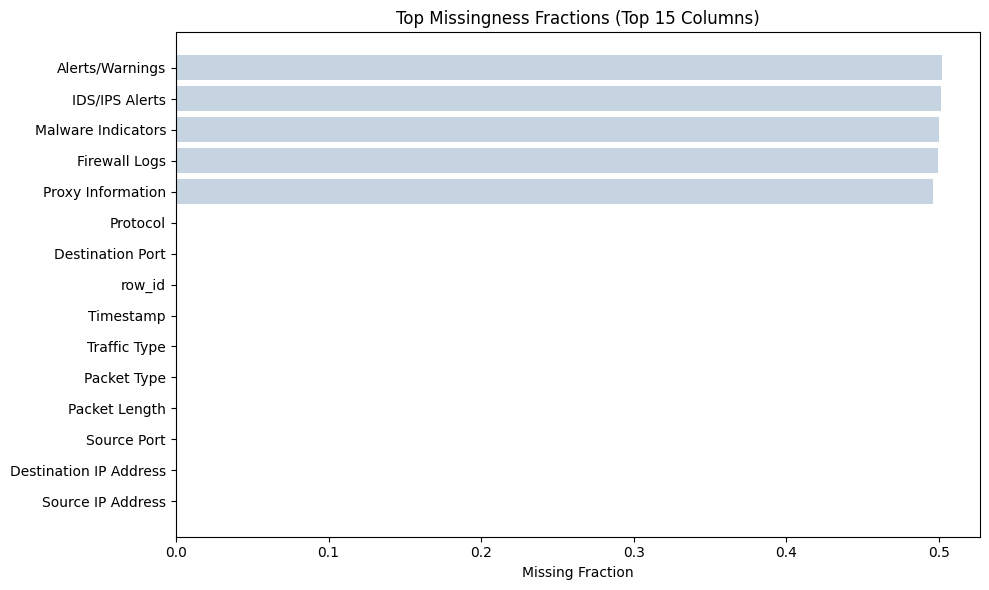

In [30]:
# Missingness plot (top 15 columns)
top_missing = missing.head(15).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(
    top_missing.index.astype(str),
    top_missing.values,
    color=COLOR_PALETTE[0],
)
plt.title("Top Missingness Fractions (Top 15 Columns)")
plt.xlabel("Missing Fraction")
plt.tight_layout()
plt.show()


## Summary statistics
Numeric summary plus a quick look at categorical cardinalities.

In [31]:
display(df.describe(include='number').T)

# Categorical columns (object/string)
cat_cols = [c for c in df.columns if df[c].dtype == 'object' or str(df[c].dtype).startswith('string')]
cat_cols = [c for c in cat_cols if c != TARGET_COL]

cardinality = pd.Series({c: df[c].nunique(dropna=True) for c in cat_cols}).sort_values(ascending=False)
display(cardinality.head(20).to_frame('n_unique'))

,count,mean,std,min,25%,50%,75%,max
Source Port,40000.0,32970.356450,18560.425604,1027.0,16850.75,32856.000,48928.25,65530.0
Destination Port,40000.0,33150.868650,18574.668842,1024.0,17094.75,33004.500,49287.00,65535.0
Packet Length,40000.0,781.452725,416.044192,64.0,420.00,782.000,1143.00,1500.0
Anomaly Scores,40000.0,50.113473,28.853598,0.0,25.15,50.345,75.03,100.0


,n_unique
row_id,40000
Source IP Address,40000
Destination IP Address,40000
Payload Data,40000
User Information,32389
Device Information,32104
Proxy Information,20148
Geo-location Data,8723
Protocol,3
Traffic Type,3


## Feature audit

This section summarizes feature quality signals (missingness, cardinality, text length) and suggests an initial action (keep/transform/drop) for modeling.

In [32]:
import numpy as np
import pandas as pd

# --- Feature audit: missingness, cardinality, text length ---

def _safe_str(x) -> str:
    try:
        return "" if pd.isna(x) else str(x)
    except Exception:
        return ""


def _text_stats(series: pd.Series) -> dict:
    # Compute cheap length stats on a sample to avoid blowing up on huge columns.
    # (Dataset is ~40k rows so this is safe, but we still keep it bounded.)
    sample = series.dropna()
    if len(sample) > 10_000:
        sample = sample.sample(10_000, random_state=42)

    lengths = sample.map(lambda v: len(_safe_str(v))).astype(int)
    if lengths.empty:
        return {"avg_len": 0.0, "p95_len": 0.0, "max_len": 0.0}

    return {
        "avg_len": float(lengths.mean()),
        "p95_len": float(np.percentile(lengths.to_numpy(), 95)),
        "max_len": float(lengths.max()),
    }


rows = []
for col in df.columns:
    s = df[col]
    missing_frac = float(s.isna().mean())

    # nunique(dropna=True) can be slow-ish; for this size it's OK.
    nunique = int(s.nunique(dropna=True))

    dtype = str(s.dtype)

    is_target = (col == TARGET_COL)
    is_row_id = (col.lower() == "row_id")

    # Heuristics for text-ish columns.
    is_object_like = (dtype == "object") or dtype.startswith("string")
    text = {"avg_len": np.nan, "p95_len": np.nan, "max_len": np.nan}
    if is_object_like:
        text = _text_stats(s)

    # Decision heuristics (baseline; refine as needed).
    col_lc = col.lower()

    likely_id = any(tok in col_lc for tok in ["id", "uuid", "guid"]) and not is_row_id
    likely_ip = "ip" in col_lc
    likely_timestamp = any(tok in col_lc for tok in ["time", "date", "timestamp"])
    likely_port = "port" in col_lc
    likely_free_text = bool(is_object_like and (text["p95_len"] >= 30 or text["max_len"] >= 120))

    high_missing = missing_frac >= 0.40
    high_cardinality = nunique >= 500

    # Suggested action
    if is_target:
        action = "target"
        reason = "label column"
    elif is_row_id:
        action = "drop"
        reason = "surrogate key"
    elif likely_ip:
        action = "drop"
        reason = "high-cardinality identifier (likely)"
    elif likely_id and high_cardinality:
        action = "drop"
        reason = "identifier-like + high cardinality"
    elif likely_timestamp:
        action = "transform"
        reason = "extract time-based features"
    elif likely_port:
        action = "transform"
        reason = "bucket/parse port features"
    elif likely_free_text:
        action = "drop"
        reason = "free-text/log-like (one-hot unfriendly)"
    elif high_missing and is_object_like and nunique <= 2:
        action = "keep"
        reason = "binary-ish; treat missing as category"
    elif high_missing:
        action = "drop"
        reason = "too missing (baseline)"
    elif high_cardinality and is_object_like:
        action = "drop"
        reason = "high-cardinality categorical (baseline)"
    else:
        action = "keep"
        reason = "ok for baseline"

    rows.append(
        {
            "feature": col,
            "dtype": dtype,
            "missing_%": round(missing_frac * 100, 2),
            "n_unique": nunique,
            "avg_len": None if (not is_object_like) else round(text["avg_len"], 2),
            "p95_len": None if (not is_object_like) else round(text["p95_len"], 2),
            "max_len": None if (not is_object_like) else round(text["max_len"], 2),
            "suggested_action": action,
            "reason": reason,
        }
    )

audit = pd.DataFrame(rows)
audit = audit.sort_values(by=["suggested_action", "missing_%", "n_unique"], ascending=[True, False, False]).reset_index(drop=True)

print("Feature audit (sorted by action / missingness / cardinality)")
display(audit)

print("\nSuggested drops:")
display(audit.loc[audit["suggested_action"].eq("drop"), ["feature", "dtype", "missing_%", "n_unique", "reason"]])

print("\nSuggested transforms:")
display(audit.loc[audit["suggested_action"].eq("transform"), ["feature", "dtype", "missing_%", "n_unique", "reason"]])

Feature audit (sorted by action / missingness / cardinality)


,feature,dtype,missing_%,n_unique,avg_len,p95_len,max_len,suggested_action,reason
0,IDS/IPS Alerts,object,50.12,1,10.00,10.0,10.0,drop,high-cardinality identifier (likely)
1,Proxy Information,object,49.63,20148,13.22,15.0,15.0,drop,too missing (baseline)
2,row_id,object,0.00,40000,10.00,10.0,10.0,drop,surrogate key
3,Source IP Address,object,0.00,40000,13.24,15.0,15.0,drop,high-cardinality identifier (likely)
4,Destination IP Address,object,0.00,40000,13.26,15.0,15.0,drop,high-cardinality identifier (likely)
5,Payload Data,object,0.00,40000,140.39,194.0,199.0,drop,free-text/log-like (one-hot unfriendly)
6,User Information,object,0.00,32389,12.21,17.0,24.0,drop,high-cardinality categorical (baseline)
7,Device Information,object,0.00,32104,92.03,146.0,147.0,drop,free-text/log-like (one-hot unfriendly)
8,Geo-location Data,object,0.00,8723,19.13,27.0,47.0,drop,high-cardinality categorical (baseline)
9,Alerts/Warnings,object,50.17,1,15.00,15.0,15.0,keep,binary-ish; treat missing as category



Suggested drops:


,feature,dtype,missing_%,n_unique,reason
0,IDS/IPS Alerts,object,50.12,1,high-cardinality identifier (likely)
1,Proxy Information,object,49.63,20148,too missing (baseline)
2,row_id,object,0.00,40000,surrogate key
3,Source IP Address,object,0.00,40000,high-cardinality identifier (likely)
4,Destination IP Address,object,0.00,40000,high-cardinality identifier (likely)
5,Payload Data,object,0.00,40000,free-text/log-like (one-hot unfriendly)
6,User Information,object,0.00,32389,high-cardinality categorical (baseline)
7,Device Information,object,0.00,32104,free-text/log-like (one-hot unfriendly)
8,Geo-location Data,object,0.00,8723,high-cardinality categorical (baseline)



Suggested transforms:


,feature,dtype,missing_%,n_unique,reason
23,Timestamp,"datetime64[ns, UTC]",0.0,39997,extract time-based features
24,Destination Port,int64,0.0,29895,bucket/parse port features
25,Source Port,int64,0.0,29761,bucket/parse port features


## Distribution plots (numeric)
Histograms for key numeric fields.

In [33]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols

['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']

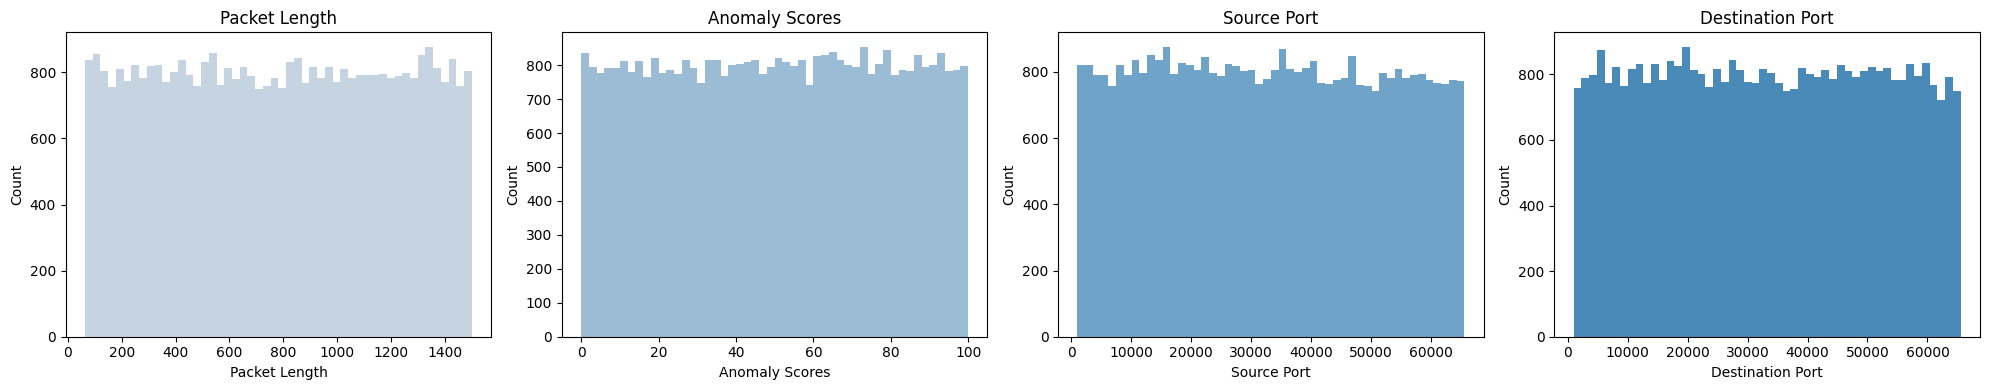

In [34]:
# Plot up to 6 numeric columns (adjust as needed)
cols_to_plot = [
    c
    for c in [
        "Packet Length",
        "Anomaly Scores",
        "Source Port",
        "Destination Port",
    ]
    if c in df.columns
]

if not cols_to_plot:
    cols_to_plot = numeric_cols[:6]

n = len(cols_to_plot)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
if n == 1:
    axes = [axes]

for i, (ax, col) in enumerate(zip(axes, cols_to_plot)):
    series = df[col].dropna()
    ax.hist(series, bins=50, color=COLOR_PALETTE[i % len(COLOR_PALETTE)])
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


## Correlation analysis (numeric)
Correlation matrix for numeric features.

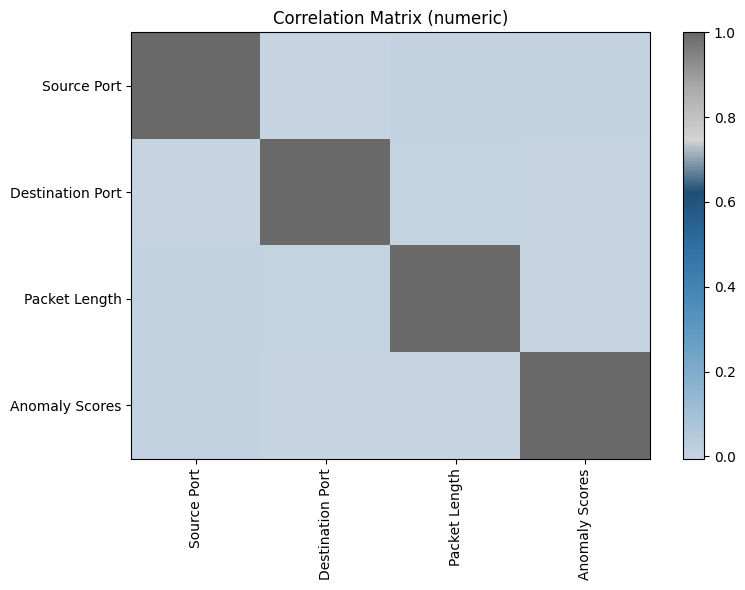

,Source Port,Destination Port,Packet Length,Anomaly Scores
Source Port,1.000000,-0.005216,0.003657,0.004826
Destination Port,-0.005216,1.000000,0.002581,-0.003616
Packet Length,0.003657,0.002581,1.000000,-0.003599
Anomaly Scores,0.004826,-0.003616,-0.003599,1.000000


In [35]:
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)

    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values, interpolation="nearest", aspect="auto", cmap=COLOR_CMAP)
    plt.title("Correlation Matrix (numeric)")
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    display(corr)
else:
    print("Not enough numeric columns for correlation analysis.")


## Class balance (`Attack Type`)
Overall distribution and distribution by shared split.

Attack Type
DDoS         13428
Malware      13307
Intrusion    13265
Name: count, dtype: int64

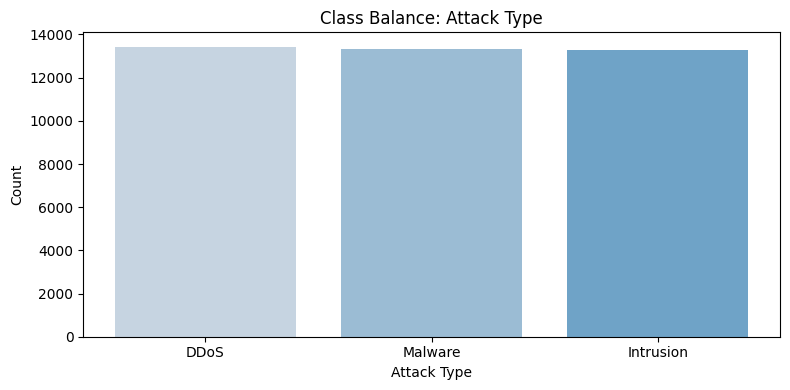

In [36]:
attack_counts = df[TARGET_COL].value_counts().sort_values(ascending=False)
display(attack_counts)

colors = [COLOR_PALETTE[i % len(COLOR_PALETTE)] for i in range(len(attack_counts))]

plt.figure(figsize=(8, 4))
plt.bar(attack_counts.index.astype(str), attack_counts.values, color=colors)
plt.title("Class Balance: Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [37]:
# Join split labels onto the cleaned dataset via row_id
df_split = df.merge(splits[['row_id', 'split']], on='row_id', how='left')

by_split = (
    df_split.groupby(['split', TARGET_COL])
    .size()
    .unstack(fill_value=0)
    .loc[['train', 'val', 'test']]
)
display(by_split)

# Normalize per split for easy comparison
display((by_split.T / by_split.sum(axis=1)).T)

Attack Type,DDoS,Intrusion,Malware
split,,,
train,9400,9285,9315
val,2014,1990,1996
test,2014,1990,1996


Attack Type,DDoS,Intrusion,Malware
split,,,
train,0.335714,0.331607,0.332679
val,0.335667,0.331667,0.332667
test,0.335667,0.331667,0.332667


## Domain-oriented slices
These views are meant to surface patterns that are meaningful in a cyber-security context.

In [38]:
def plot_top_category_by_attack(col: str, top_k: int = 10) -> None:
    """Plot top categories of `col` and their breakdown by Attack Type."""

    if col not in df.columns:
        print(f"Skipping: {col} not in dataset")
        return

    top_values = df[col].value_counts(dropna=True).head(top_k).index
    subset = df[df[col].isin(top_values)].copy()
    pivot = subset.pivot_table(
        index=col,
        columns=TARGET_COL,
        values="row_id",
        aggfunc="count",
        fill_value=0,
    )

    pivot = pivot.loc[top_values]  # preserve frequency order

    series_colors = [
        COLOR_PALETTE[i % len(COLOR_PALETTE)] for i in range(pivot.shape[1])
    ]

    pivot.plot(kind="bar", figsize=(12, 5), color=series_colors)
    plt.title(f"Top {top_k} {col} values by Attack Type")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


display(classes)


{'target': 'Attack Type',
 'classes': ['DDoS', 'Intrusion', 'Malware'],
 'class_to_index': {'DDoS': 0, 'Intrusion': 1, 'Malware': 2}}

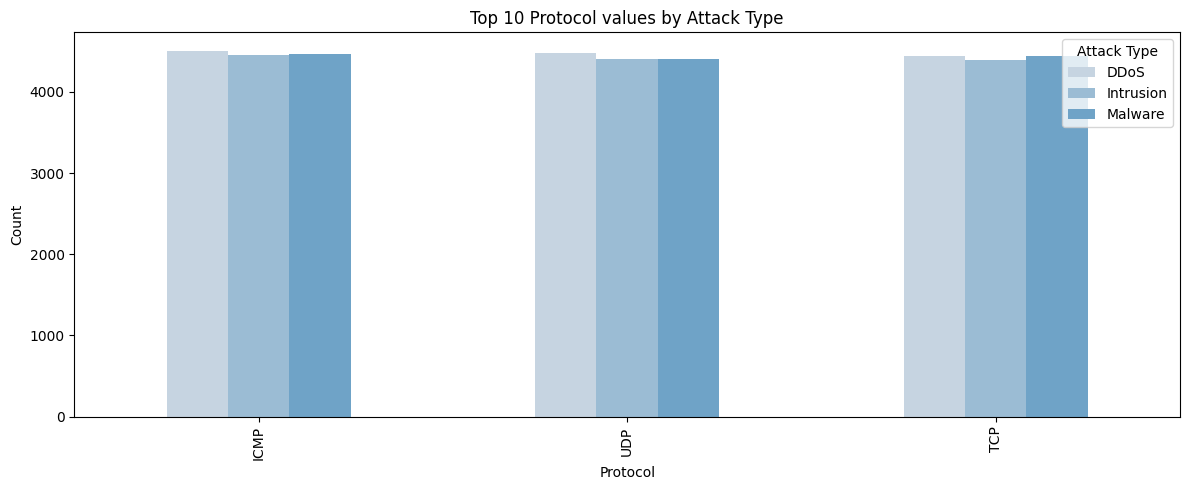

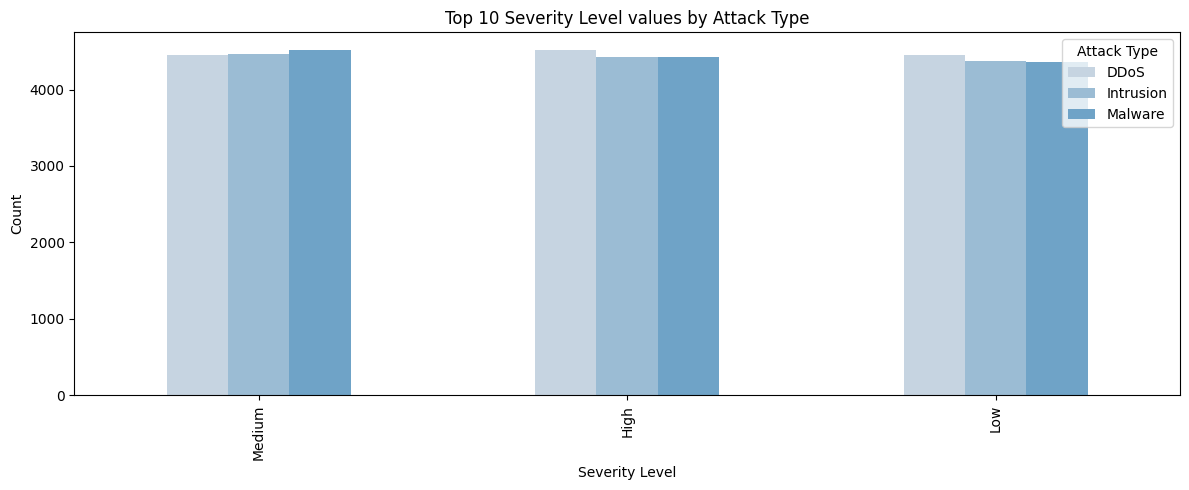

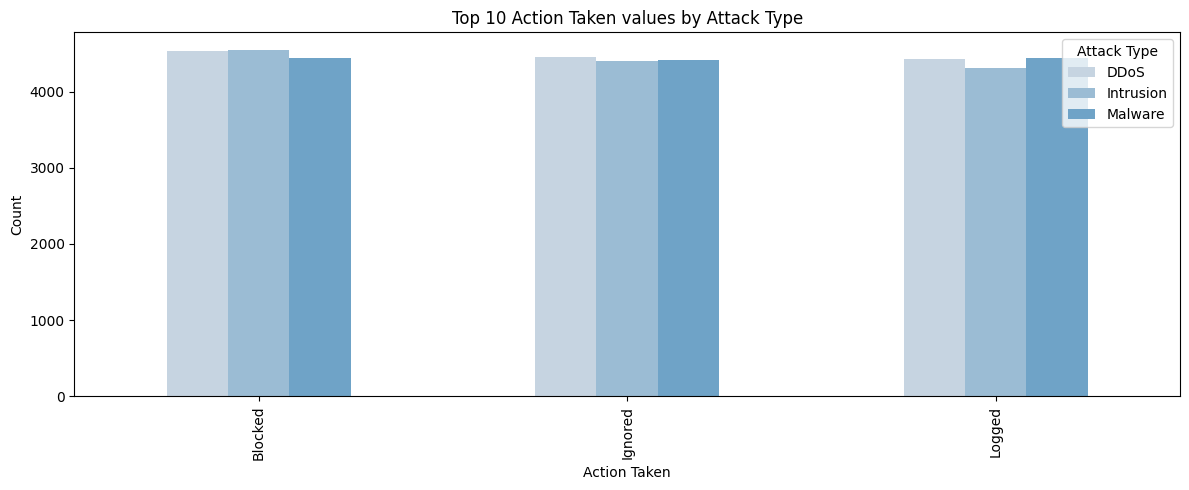

In [39]:
# Protocol / Severity / Action Taken are common domain signals
plot_top_category_by_attack('Protocol', top_k=10)
plot_top_category_by_attack('Severity Level', top_k=10)
plot_top_category_by_attack('Action Taken', top_k=10)

## Notes / Next steps
- Use this EDA to decide which columns to drop (high-cardinality IDs, free-text payloads) vs encode (categoricals).
- For experiments, use a `ColumnTransformer` with `OneHotEncoder(handle_unknown='ignore')` for categorical predictors and scaling for models that need it (e.g., logistic regression, SVM, KNN).